## Detection with VGG Network
In this notebook, we are going to perform lesion detection with simple VGG16 network as baseline to compare it with Soft Attention version.

In [1]:
!pip install git+https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git --no-deps

  Cloning https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to /tmp/pip-req-build-filuao71
  Running command git clone --filter=blob:none --quiet https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git /tmp/pip-req-build-filuao71
  Resolved https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to commit e8b077f83a61c58c831c1a499bea9004b6879bc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for skin_cancer_detection: filename=skin_cancer_detection-0.1.0-py3-none-any.whl size=6585 sha256=a4570764051b4d83a80a9b153c9081d831a78928f255edf10abc58b57778b2c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-b8zgld50/wheels/1c/73/8d/15507a4fb68edbf3c8bf56d26a749022d0075ab6b50ec069ff
Successfully built skin_cancer_detection


In [3]:
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import vgg16_bn
from torchvision.transforms import v2 as tfs

from exp_tools.basic_utils import init_module, plot_history
from exp_tools.data_utils import HAM10000Dataset, Explorer
from exp_tools.trainer import Trainer

### Loading the Dataset
Now, we are going to load the HAM10000 dataset, following the same previous pipeline.

In [10]:
image_size = (224, 224)
train_transform = tfs.Compose([
    tfs.ToImage(),
    tfs.RandomHorizontalFlip(0.5),
    tfs.ColorJitter(brightness=(0.5, 1.5), contrast=0.2),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])
test_transform = tfs.Compose([
    tfs.ToImage(),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])

In [11]:
# local_path = "../data/HMNIST"
kaggle_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

train_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=train_transform,
    target_transform=torch.tensor,
    split="train"
)
test_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=test_transform,
    target_transform=torch.tensor,
    split="test"
)
print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 8012
Test samples: 2003


### Preparing Sampler and DataLoader
Now, we are preparing the data loader, we will again use weighted random sampler to manage class imbalance.

In [12]:
label_weights = 1 / train_set.sample_dist
sample_weights = [
    label_weights[train_set.label_map[label_str]].item()
    for label_str in train_set.metadata.dx
]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_set), replacement=True)

In [13]:
batch_size = 64
num_workers = 4
train_dl = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
test_dl = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

### Preparing the Model
We then initialize our VGG16 model with Batch Normalization and perform parameter initialization.

In [23]:
model = vgg16_bn(num_classes=len(train_set.label_map))
model.apply(init_module)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Training the Model
Now, we will train our VGG16 model.
#### Organizing the Metrics
First we will organize the metrics to collect while training.

In [15]:
def class_wise_precision(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None, zero_division=0.0)
    return {
        label_str: precision[label_id] for label_str, label_id in train_set.label_map.items()
    }

def class_wise_recall(y_true, y_pred):
    recall = recall_score(y_true, y_pred, average=None, zero_division=0.0)
    return {
        label_str: recall[label_id] for label_str, label_id in train_set.label_map.items()
    }

metrics = {
    "accuracy": accuracy_score,
    "average_precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0),
    "average_recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro", zero_division=0.0),
    "precision": class_wise_precision,
    "recall": class_wise_recall
}

#### Training
The following code starts the training loop.

In [26]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(
    max_epochs=50, device="cuda", clip_grad=True, clip_val=2.0, metrics=metrics
)

In [27]:
trainer.fit(model, criterion, optimizer, train_dl, test_dl)

Epoch 1/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 2.13403572723143
Val loss: 2.1765936774964696
Epoch 2/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.6805348350474434
Val loss: 1.8925083343588704
Epoch 3/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.5124479132893678
Val loss: 1.9314464735972898
Epoch 4/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.4208566030144274
Val loss: 1.8375877038990922
Epoch 5/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.3497041905455986
Val loss: 1.8799225036584908
Epoch 6/50
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.2638144847814643
Val loss: 1.588619035657977
Epoch 7/50
[-------------------------------------

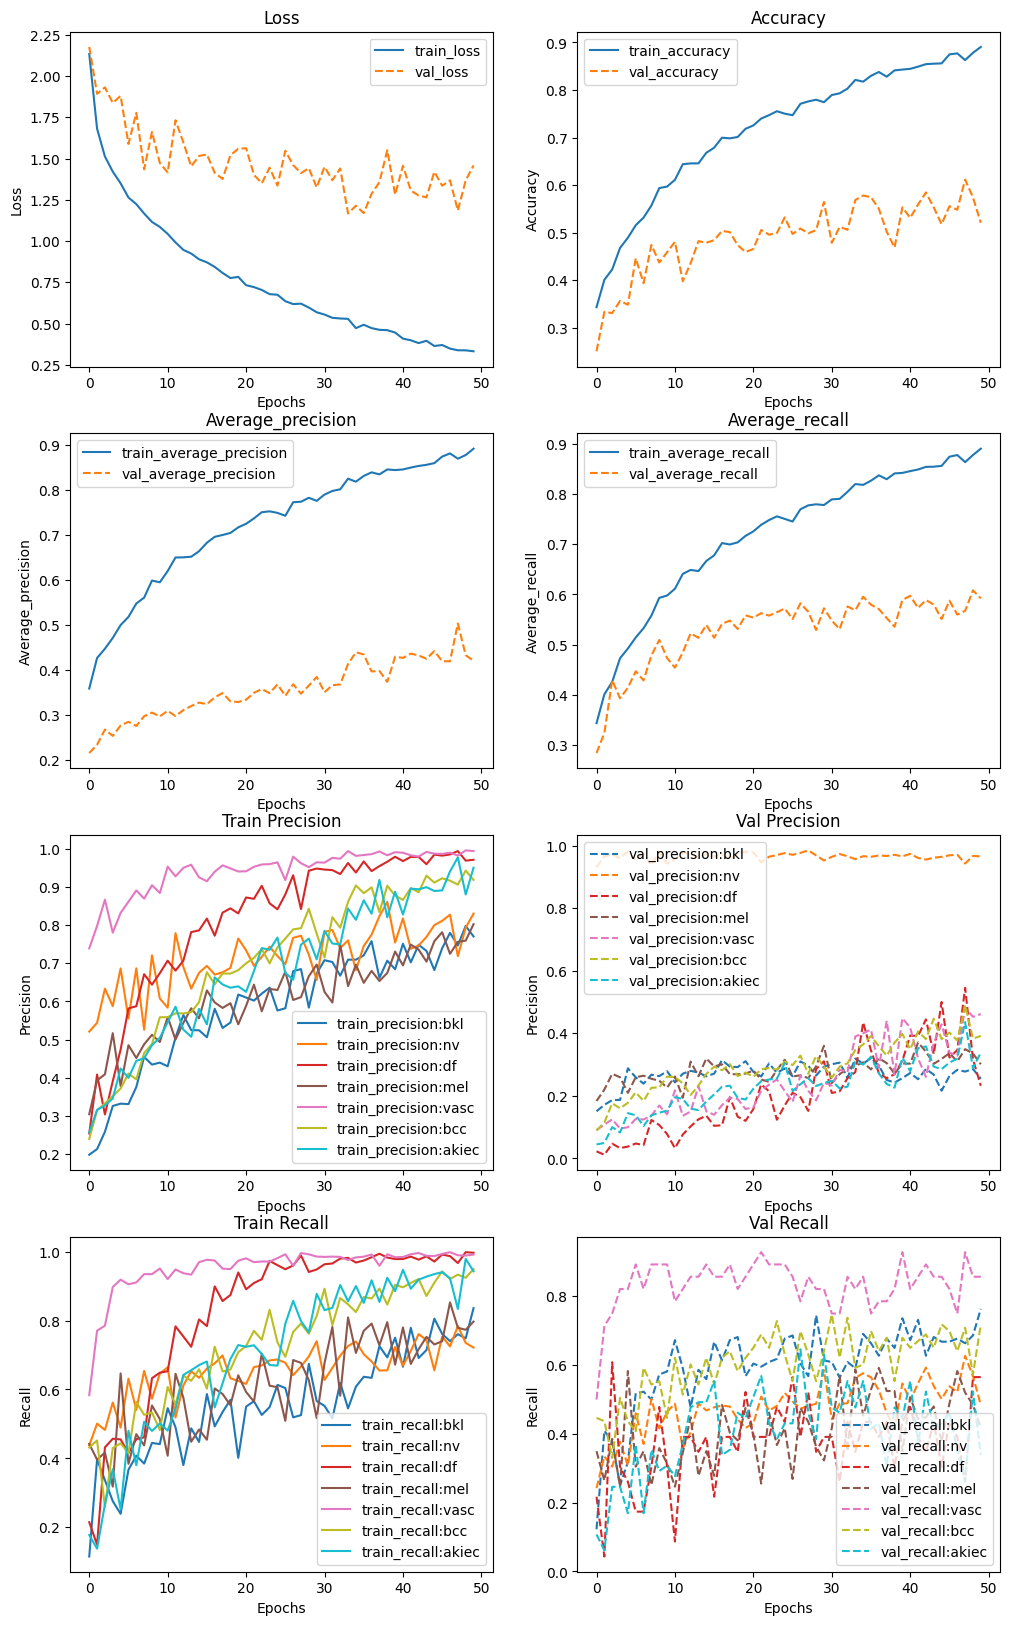

In [28]:
trainer.current_history.plot_history()

In [30]:
torch.save(model.state_dict(), "model_var_vgg16-50.pt")